In [1]:
import time
import os
from os.path import join, exists
import numpy as np
import pandas as pd
import cv2
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from tqdm import tqdm
import skimage.io
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
import openslide

In [2]:
dataset_path = "/media/matthew/External/Kaggle/PANDA_Challenge"
train_image_path = join(dataset_path, "train_images")
train_mask_path = join(dataset_path, "train_label_masks")
patches_path = join(dataset_path, "extracted_patches")

In [3]:
train_df = pd.read_csv(join(dataset_path, 'train.csv'), index_col='image_id')
train_rad = train_df[train_df['data_provider'] == 'r']
train_kar = train_df[train_df['data_provider'] == 'k']
print(len(train_rad), len(train_kar))

5160 5456


In [4]:
train_rad.head()

,data_provider,isup_grade,gleason_score
image_id,,,
0018ae58b01bdadc8e347995b69f99aa,r,4,4+4
004dd32d9cd167d9cc31c13b704498af,r,1,3+3
0068d4c7529e34fd4c9da863ce01a161,r,3,4+3
006f6aa35a78965c92fffd1fbd53a058,r,3,4+3
007433133235efc27a39f11df6940829,r,0,negative


In [5]:
cmap_r = ListedColormap(['white', 'lightgrey', 'green', 'orange', 'red', 'darkred'])
norm_r = Normalize(vmin=0, vmax=5, clip=True)

In [7]:
class PatchSlicer:
    def __init__(self, wsi, step_size=16):
        self.wsi = wsi
        self.step_size = step_size
        self.x = 0
        self.y = 0

    def generator(self):
        self.width = self.wsi.shape[0]
        self.height = self.wsi.shape[1]
        while self.y + self.step_size < self.height:
            while self.x + self.step_size < self.width:
                yield self.wsi[self.x:self.x + self.step_size, self.y:self.y + self.step_size], (self.x, self.y)
                self.x += self.step_size
            self.x = 0
            self.y += self.step_size

In [8]:
def generate_patch(image_id, plot=True):
    image_path = join(train_image_path, image_id + '.tiff')
    mask_path = join(train_mask_path, image_id + '_mask.tiff')
#     try:
    image = openslide.OpenSlide(image_path)
    mask = openslide.OpenSlide(mask_path)
    small_image = skimage.io.MultiImage(image_path)[-1]

    content = np.argwhere(np.sum(small_image, axis=2) != 765)
    top, left = np.min(content, axis=0)
    bottom, right = np.max(content, axis=0) + 1
    cropped = small_image[top:bottom, left:right]

    ps = PatchSlicer(cropped)
    mean_values = []
    coords = []
    for patch, coord in ps.generator():
        mpv = patch.mean()
        if mpv > 240: continue
        mean_values.append(mpv)
        coords.append(((coord[1]+left)*16,(coord[0]+top)*16))

    xy = sorted(zip(mean_values, coords))
#     except:
#         return
    
    if plot:
        val, coord = xy[0]
        print(coord)
        ax = plt.subplot(1, 2, 1)
        ax.imshow(np.array(image.read_region(coord, 0, (256,256))))
        ax.axis('off')

        ax = plt.subplot(1, 2, 2)
        ax.imshow(np.array(mask.read_region(coord, 0, (256,256)))[:,:,0], cmap=cmap_r, norm=norm_r)
        ax.axis('off')
            
    return

(2304, 14336)


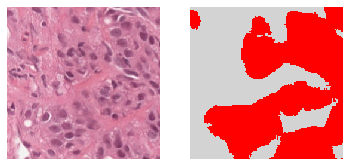

In [9]:
generate_patch('0018ae58b01bdadc8e347995b69f99aa')

In [27]:
def get_features(image_id, plot=True, topk=12):
    image_path = join(train_image_path, image_id + '.tiff')
    mask_path = join(train_mask_path, image_id + '_mask.tiff')
    try:
        image = skimage.io.MultiImage(image_path)[0]
        mask = skimage.io.MultiImage(mask_path)[-1]
        
        content = np.argwhere(np.sum(image, axis=2) != 765)
        top, left = np.min(content, axis=0)
        bottom, right = np.max(content, axis=0) + 1
        cropped = image[top:bottom, left:right]
        cropped_mask = mask[top:bottom, left:right, 0]

        ps = PatchSlicer(cropped)
        mean_values = []
        coords = []
        for patch, coord in ps.generator():
            mpv = patch.mean()
            if mpv > 240: continue
            mean_values.append(mpv)
            coords.append(coord)

        xy = sorted(zip(mean_values, coords))
    except:
        return np.ones((6)) * np.nan
    
    counts = np.zeros((6))
    for mpv, coord in xy:
        y, x = coord
        uv, uc = np.unique(cropped_mask[y : y + 256, x : x + 256], return_counts=True)
        for v, c in zip(uv, uc):
            counts[v] += c
    counts /= np.sum(counts)
    
    if plot:
        image = openslide.OpenSlide(image_path)
        mask = openslide.OpenSlide(mask_path)
        cols = 10
        rows = 10
        plt.figure(figsize=(20, 20))
        plt.subplots_adjust(wspace=0, hspace=0)

        i = 1
        for v, coord in xy:
            y,x = coord
            x *= 16
            y *= 16
            ax = plt.subplot(rows, cols, i)
            ax.imshow(np.array(image.read_region((x,y), 2, (256,256))))
            ax.axis('off')
            if i == 100: break
            i += 1

        plt.figure(figsize=(20, 20))
        plt.subplots_adjust(wspace=0, hspace=0)

        i = 1
        for v, coord in xy:
            y,x = coord
            x *= 16
            y *= 16
            ax = plt.subplot(rows, cols, i)
            ax.imshow(np.array(mask.read_region((x,y), 2, (256,256)))[:,:,0], cmap=cmap_r, norm=norm_r)
            ax.axis('off')
            if i == 100: break
            i += 1
            
    return counts

/home/matthew/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


array([nan, nan, nan, nan, nan, nan])

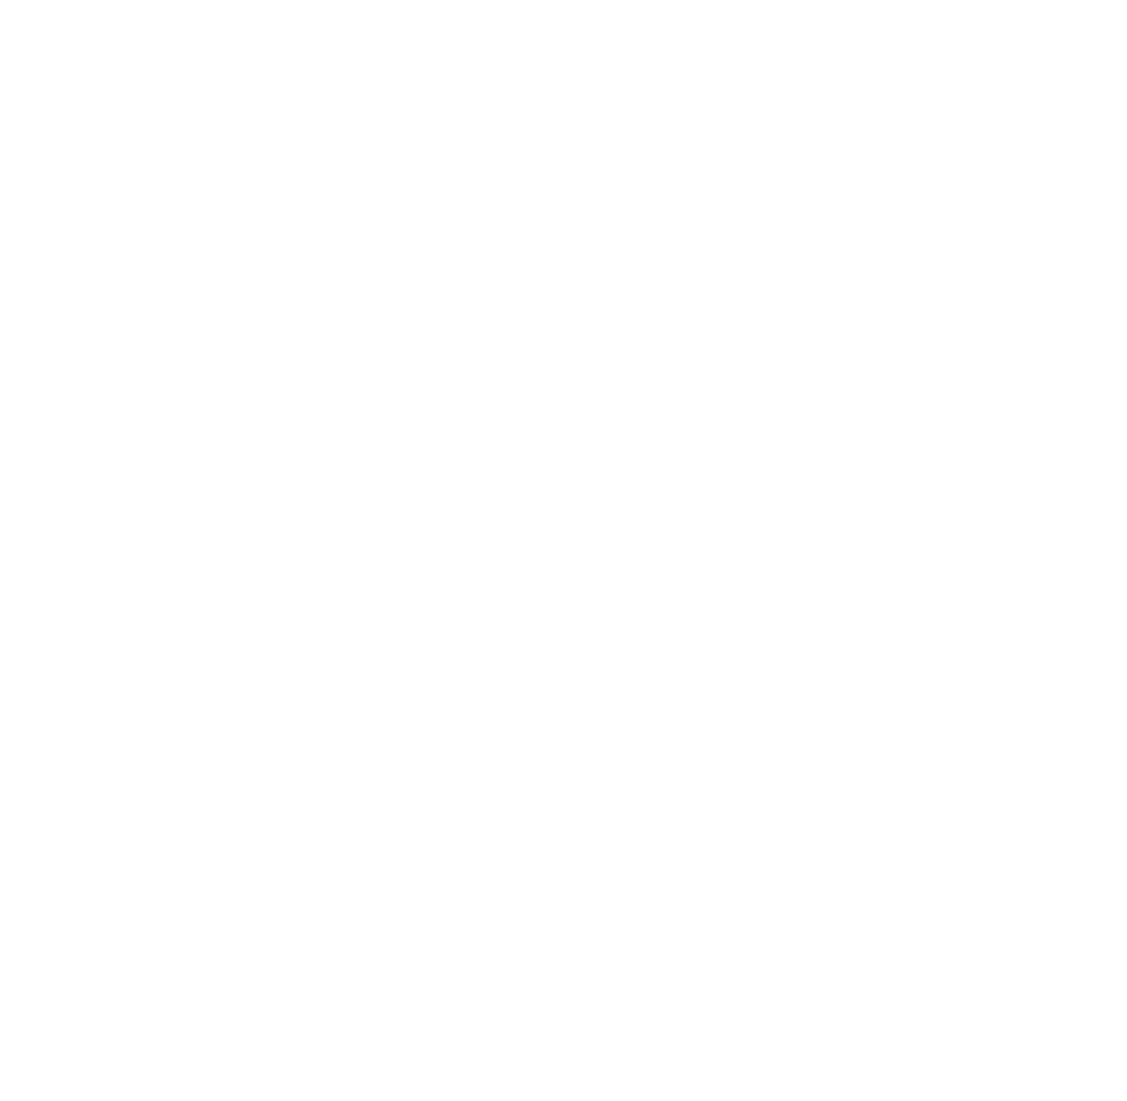

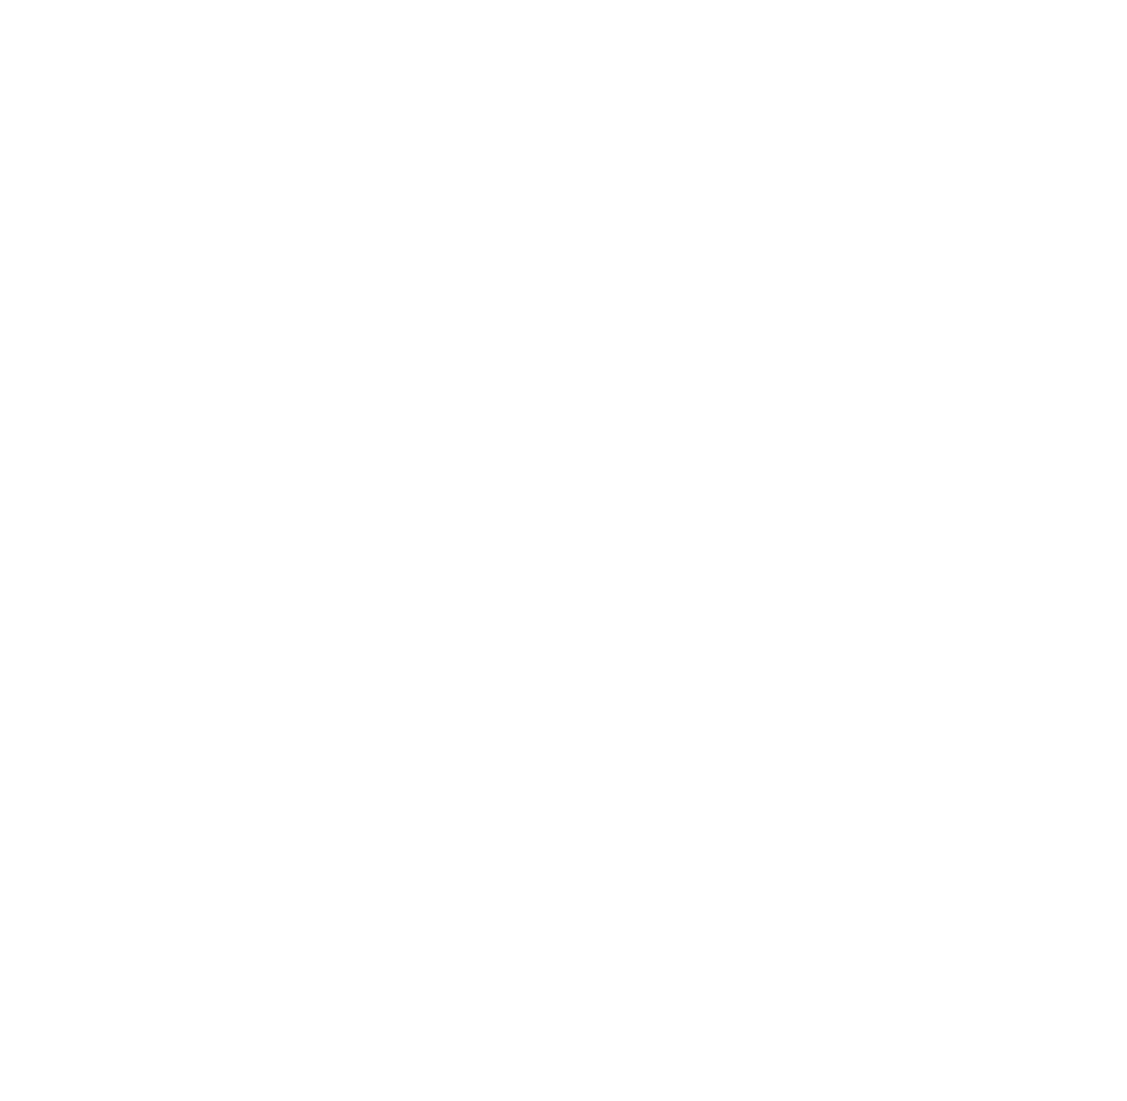

In [28]:
get_features('0018ae58b01bdadc8e347995b69f99aa')